# Exercise 1: GD on a 1D Function


Eta        | Final Theta     | Final Loss      | Behavior
------------------------------------------------------------
0.05       | 2.6353          | -0.8670         | Slow convergence (Under-stepping)
0.2        | 2.9999          | -1.0000         | Fast convergence (perfect stepping)
1.0        | 0.0000          | 8.0000          | Oscillation (Bouncing between 0 and 6)
------------------------------------------------------------


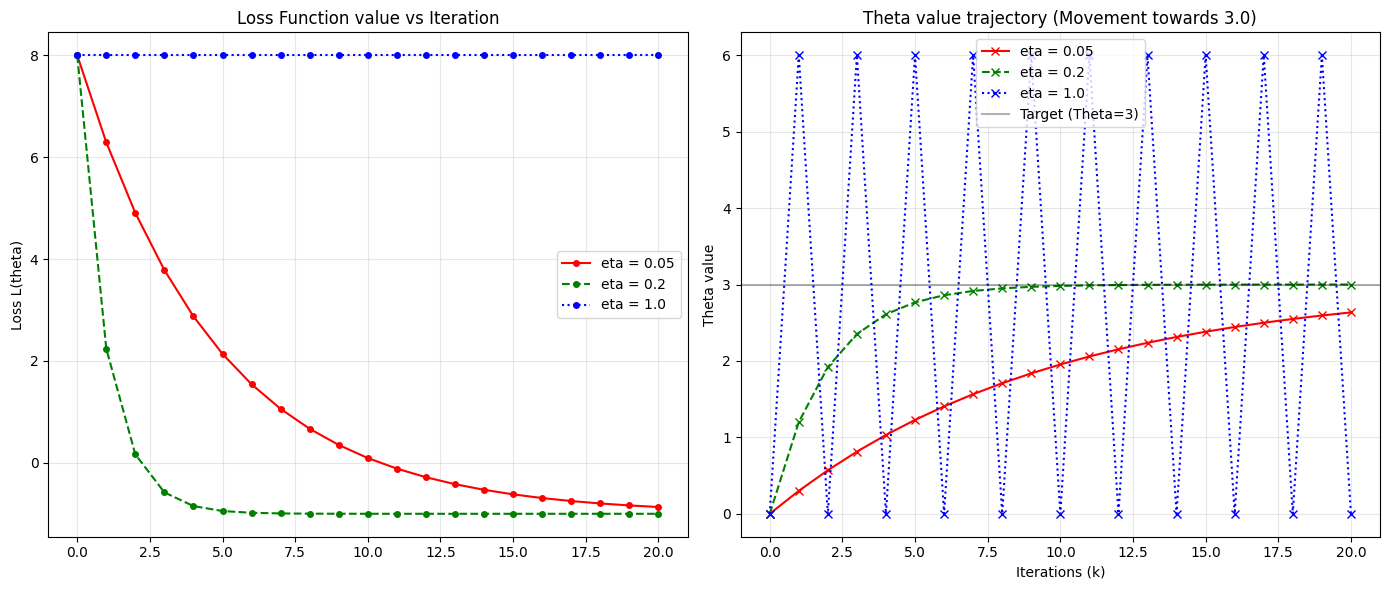

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # ==========================================
# 1. Define the function and gradient of it
# # ==========================================


def L(theta):
    """The loss function l(theta) = (theta -3)^2 + 1"""
    return ((theta - 3) ** 2) - 1


def grad_L(theta):
    """
    The gradient of the loss function.
    Derivate of (theta -3)**2 - 1 is 2(theta-3)
    """
    return 2 * (theta - 3)


# # ==========================================
# 2. Implement Gradient Descent
# # ==========================================


def run_gradient_descent(start_theta, learning_rate, maxitr):
    """
    Performs Gradient Descent till maxitr

    Returns:
    - theta_history: list of theta values at each step
    - loss_history: list of function values at each step
    """

    # Initial parameters
    theta = start_theta

    # Lists to store history
    # Later than used for plotting
    theta_history = [theta]
    loss_history = [L(theta)]

    for i in range(maxitr):
        # 1. Compute Gradient
        gradient = grad_L(theta)

        # 2. Update Theta (The Core Formula: theta_new = theta_old - eta * grad)
        theta = theta - learning_rate * gradient

        # save snapshot
        theta_history.append(theta)
        loss_history.append(L(theta))

    return theta_history, loss_history


# ==========================================
# 3. With different learning rates
# ==========================================
start_theta = 0.0
maxitr = 20
learning_rates = [0.05, 0.2, 1.0]

# Prepare the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
colors = ["red", "green", "blue"]
styles = ["-", "--", ":"]

print(f"{'Eta':<10} | {'Final Theta':<15} | {'Final Loss':<15} | {'Behavior'}")
print("-" * 60)  # divider

for i, eta in enumerate(learning_rates):
    # Run the algorithm
    thetas, losses = run_gradient_descent(start_theta, eta, maxitr)

    # Plot1: Loss vs Iterations tells the convergence
    ax1.plot(losses, label=f"eta = {eta}", color=colors[i], linestyle=styles[i], marker="o", markersize=4)

    # Plot2: theta trajectory on the line
    # Plotting the iterations vs thera to show the movement over the time on the real line
    ax2.plot(thetas, label=f"eta = {eta}", color=colors[i], linestyle=styles[i], marker="x")

    final_theta = thetas[-1]
    final_loss = losses[-1]

    behaviour = ""
    if eta == 0.05:
        behaviour = "Slow convergence (Under-stepping)"
    elif eta == 0.2:
        behaviour = "Fast convergence (perfect stepping)"
    elif eta == 1.0:
        behaviour = "Oscillation (Bouncing between 0 and 6)"

    print(f"{eta:<10} | {final_theta:<15.4f} | {final_loss:<15.4f} | {behaviour}")

print("-" * 60)

# ==========================================
# 4. Final plotting
# ==========================================

# Loss plot configurations
ax1.set_title("Loss Function value vs Iteration")
ax2.set_xlabel("Iteration (k)")
ax1.set_ylabel("Loss L(theta)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Trajectory plot settings
ax2.set_title("Theta value trajectory (Movement towards 3.0)")
ax2.set_xlabel("Iterations (k)")
ax2.set_ylabel("Theta value")
ax2.axhline(y=3.0, color="black", linestyle="-", alpha=0.3, label="Target (Theta=3)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## OBSERVATIONS & COMMENTS

### 1. Eta = 0.05 (Small Step)

- **Behavior:** The loss decreases monotonically but very slowly.
- **Theoretical Link:**  
  When the step-size is too small, we take tiny steps down the hill.  
  We are safe, but it takes many iterations to reach the minimum.

### 2. Eta = 0.2 (Medium Step)

- **Behavior:** The loss decreases rapidly and settles at the minimum _(θ = 3)_.
- **Theoretical Link:**  
  This is the _“Just Right”_ zone. The step size matches the  
  scale of the gradient, allowing efficient descent without overshooting.

### 3. Eta = 1.0 (Large Step)

- **Behavior:** The theta value bounces perfectly between **0.0** and **6.0**.  
  The loss never goes to **1.0** (the minimum); it stays stuck at **10.0**.
- **Theoretical Link:**  
  This demonstrates **oscillation** caused by a step size  
  at the limit of stability. The step is so large it jumps strictly to the  
  other side of the valley at the exact same height, never descending.

---

### Note on Convexity

Since the function

(theta - 3)^2 + 1

is **strictly convex** (a perfect bowl), there are no local minima to get stuck in.  
The only risks are **slow convergence** or **divergence** due to step size.


# Exercise 2: Backtracking Line Search


Start Theta  | Final Theta  | Converged To 
------------------------------------------------------------
Running for labels0...
   -> Converged at iter 19: grad_norm=0.000006, step_norm=0.000001
-2.0         | 1.2247       | Right Min (+1.22)
------------------------------------------------------------
Running for labels1...
   -> Converged at iter 18: grad_norm=0.000006, step_norm=0.000001
0.5          | 1.2247       | Right Min (+1.22)
------------------------------------------------------------
Running for labels2...
   -> Converged at iter 19: grad_norm=0.000006, step_norm=0.000001
2.0          | -1.2247      | Left Min (-1.22)
------------------------------------------------------------


<function matplotlib.pyplot.show(close=None, block=None)>

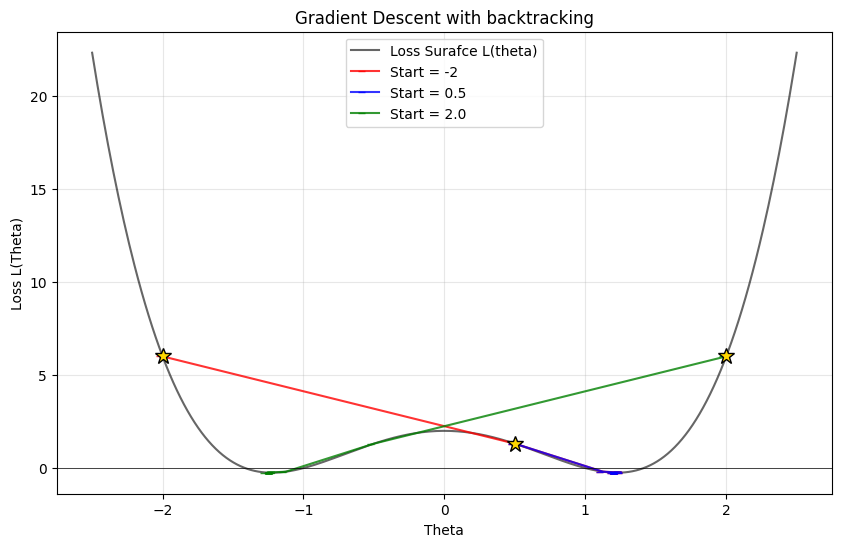

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Define the function and its Gradient
# ==========================================


def L(theta):
    """
    Non-convex function: L(theta) = theta^4 - 3*theta^2 + 2
    this is a 'double-well'potential. The curve looks like a “W”
    """
    return theta**4 - 3 * (theta**2) + 2


def grad_L(theta):
    """
    Gradient: 4*theta^3 - 6*theta
    """
    return 4 * (theta**3) - (6 * theta)


# ==========================================
# 2. Backtracking Line Search (Armijo)
# ==========================================


def backtracking(L, grad_L, theta, eta0=1.0, beta=0.5, c=1e-4):
    """
    Return a step size 'eta' that satisfies the Armijo condition:
    L(theta - eta*grad) <= L(theta) - c * eta * ||g||^2

    Inputs:
    - L:      R^n -> R
    - grad_L: R^n -> R^d
    - theta:  current point (np.ndarray)
    - eta0:   initial step size (start large)
    - beta:   shrinking factor in (0,1) (e.g. 0.5 cuts it in half)
    - c:      Armijo constant in (0,1) (strictness to decrease)
    """

    eta = eta0
    g = grad_L(theta)
    g_norm2 = np.dot(g, g)  # also For 1D, dot product is just square => g**2

    # Keep on shrinkning until the new loss is NOT good enough
    while L(theta - eta * g) > L(theta) - c * eta * g_norm2:
        eta *= beta

    return eta


# ==========================================
# 3. Gradient Descent with Backtracking
# ==========================================
def GD_with_backtracking(theta_0, maxitr=1000, tolL=1e-6, toltheta=1e-6):
    """
    Implement GD with the stopping criteria
    1. Gradient is close to - (Mathematical Minimum)
    2. Step size is very small(Practiacl Scaling)
    """
    theta = theta_0
    history = [theta]

    for i in range(maxitr):
        # 1. calculate dynamic steo size for this specific spot
        eta = backtracking(L, grad_L, theta, eta0=1.0, beta=0.5)

        # 2. update the values
        grad = grad_L(theta)
        theta_new = theta - eta * grad

        # 3. checking stopping criterias
        grad_norm = np.abs(grad)  # Norm of gradient
        step_norm = np.abs(theta_new - theta)  # Norm of the step (change in theta)

        # record new theta anyway
        history.append(theta_new)

        # Check stopping criteria
        if (grad_norm < tolL) or (step_norm < toltheta):
            print(f"   -> Converged at iter {i}: grad_norm={grad_norm:.6f}, step_norm={step_norm:.6f}")
            break

        # update
        theta = theta_new

    return np.array(history)


# ==========================================
# 4. Run the experiment & visualization
# ==========================================
start_points = [-2.0, 0.5, 2.0]
colors = ["red", "blue", "green"]
labels = ["Start = -2", "Start = 0.5", "Start = 2.0"]

# prepare the background curves
x_grid = np.linspace(-2.5, 2.5, 400)
y_grid = L(x_grid)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, y_grid, "k-", linewidth=1.5, alpha=0.6, label="Loss Surafce L(theta)")

print(f"{'Start Theta':<12} | {'Final Theta':<12} | {'Converged To'} ")
print("-" * 60)

for i, theta0 in enumerate(start_points):
    print(f"Running for labels{i}...")

    # Run optimization
    path = GD_with_backtracking(theta0)

    # plot trajectory
    path_y = L(path)
    plt.plot(path, path_y, marker=0, markersize=5, linestyle="-", color=colors[i], label=labels[i], alpha=0.8)

    # mark the start
    plt.plot(path[0], path_y[0], marker="*", markersize=12, color="gold", markeredgecolor="black")

    # print stats
    converged_to = "Left Min (-1.22)" if path[-1] < 0 else "Right Min (+1.22)"
    print(f"{theta0:<12} | {path[-1]:<12.4f} | {converged_to}")
    print("-" * 60)


plt.title("Gradient Descent with backtracking")
plt.xlabel("Theta")
plt.ylabel("Loss L(Theta)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color="black", linewidth=0.5)
plt.show

---

## 5. Discussion & Reflection

**DISCUSSION**

### 1. Stopping Criteria (Class Implementation)

We now use two checks to stop the loop early:

* **`grad_norm < tolL`** — Confirms we are mathematically at a flat spot (stationary point).
* **`step_norm < toltheta`** — Confirms we have stopped moving.
  This is crucial when the learning rate (`eta`) becomes very small due to backtracking, which can stall the algorithm even if the gradient is not exactly zero.

---

### 2. Why do different initializations converge to different minima?

- The function is **non-convex (double-well)**.
- **Start = −2** → Falls into the **left valley**.
- **Start = 2** → Falls into the **right valley**.
- **Start = 0.5** → On the right slope of the central hill → Falls **right**.

---

### 3. Failure of Constant Step Size

- Backtracking prevents divergence on the steep walls (at (x = 2) or (x = -2)) by **drastically shrinking `eta`**,
  while allowing **larger steps near the bottom**.


# Exercise 3: GD in 2D


Running GD with eta=0.02...
Running GD with eta=0.05...
Running GD with eta=0.1...
   -> Diverged at iteration 5!


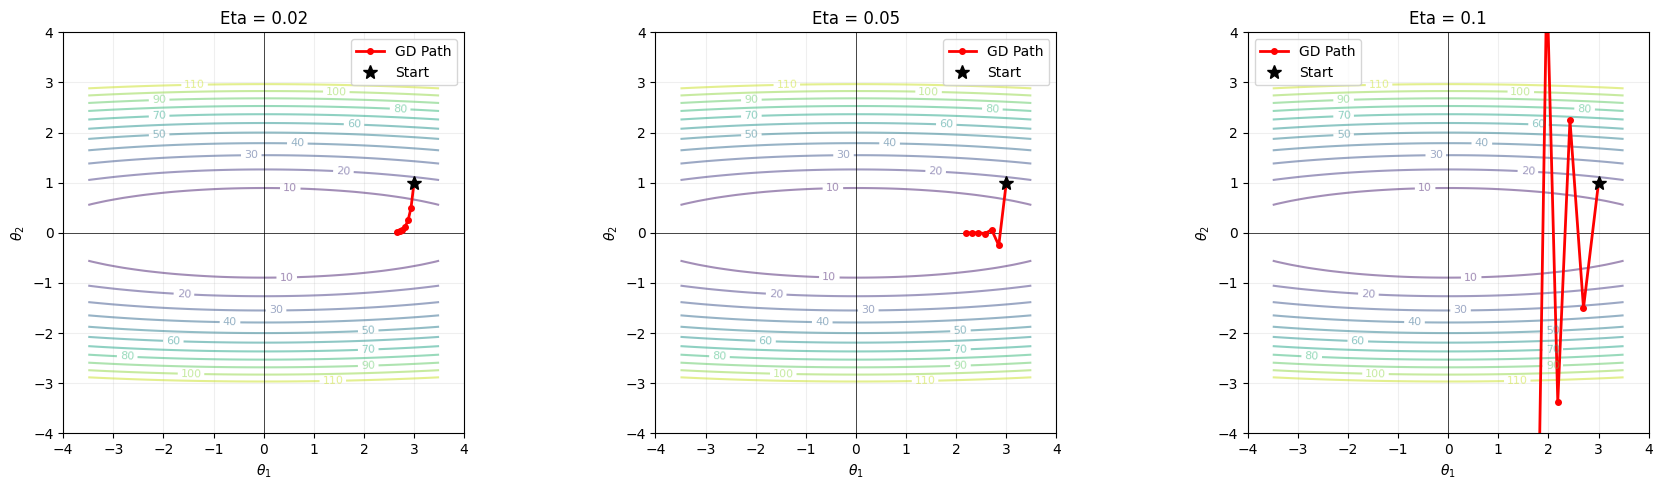

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Define the Problem (Ill-Conditioned Matrix)
# ==========================================
# A = [[1, 0], [0, 25]]
# Eigenvalues are 1 and 25. Condition number = 25.
A = np.diag([1.0, 25.0])


def grad_L(theta):
    """
    Gradient of L(theta) = 1/2 * theta.T * A * theta
    Nabla L = A * theta
    """
    return A @ theta


# ==========================================
# Gradient Descent implementation (2D)
# ==========================================


def gd_2d_fixed_step(start_theta, eta, n_iterations):
    """
    Performs GD with a FIXED step size (eta).
    We use this instead of Backtracking because Exercise 3 specifically
    asks to demonstrate what happens when eta is chosen poorly.
    """
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]

    for k in range(n_iterations):
        g = grad_L(theta)

        # Standard Update Rule (Fixed Eta)
        theta = theta - eta * g

        # Safety break if values explode (divergence)
        if np.linalg.norm(theta) > 10:
            print(f"   -> Diverged at iteration {k}!")
            break

        history.append(theta.copy())
    return np.array(history)


# ==========================================
# 3. Visualization Helper ==========================================
def quad_levelsets(ax, A, xlim=(-3.5, 3.5), ylim=(-3, 3), ngrid=100, ncontours=12):
    """
    Plots the level sets using the exact formula from class:
    0.5*(A[0,0]*X**2 + 2*A[0,1]*X*Y + A[1,1]*Y**2)

    Modified slightly to take 'ax' for subplotting.
    """
    xs = np.linspace(xlim[0], xlim[1], ngrid)
    ys = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(xs, ys)

    # This handles non-diagonal A correctly (includes X*Y term)
    Z = 0.5 * (A[0, 0] * X**2 + 2 * A[0, 1] * X * Y + A[1, 1] * Y**2)

    cs = ax.contour(X, Y, Z, levels=ncontours, cmap="viridis", alpha=0.5)
    ax.clabel(cs, inline=True, fontsize=8)

    ax.axhline(0, lw=0.5, color="k")
    ax.axvline(0, lw=0.5, color="k")

    # Equivalent to plt.gca().set_aspect('equal', 'box')
    ax.set_aspect("equal", "box")

    ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$")
    # important for divergent cases to lock the axes
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    ax.grid(alpha=0.2)


# ==========================================
# 4. Run Experiments
# ==========================================
etas = [0.02, 0.05, 0.1]
start_theta = [3.0, 1.0]  # Start far away to see the path
#  to clearly spot the divergence
iterations = 20 if eta < 0.08 else 6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, eta in enumerate(etas):
    ax = axes[i]

    # 1. Draw the map (using class-style levelsets)
    quad_levelsets(ax, A)

    # 2. Run GD (Fixed Step)
    print(f"Running GD with eta={eta}...")
    path = gd_2d_fixed_step(start_theta, eta, iterations)

    # 3. Overlay the iterates theta^(k)
    ax.plot(path[:, 0], path[:, 1], "o-", linewidth=2, color="red", markersize=4, label="GD Path")
    ax.plot(start_theta[0], start_theta[1], "k*", markersize=10, label="Start")

    ax.set_title(f"Eta = {eta}")
    ax.legend()


plt.tight_layout()
plt.show()

## 5. Comments & Analysis

**Analysis of Ill-Conditioning**

### 1. Elongated Ellipses

- Using the class formula, we see the level sets are **narrow ellipses**.
- $A_{1,1} = 25$ means the valley is **25× steeper in the Y-direction than in the X-direction**.

### 2. Zig-Zag Behavior ($\eta = 0.05$)

- The gradient points **perpendicular to the contour lines**.
- Because the valley is narrow, the gradient points strongly _across_ the valley (vertical) rather than _along_ the valley (horizontal toward the minimum).
- At $\eta = 0.05$, we jump all the way to the opposite wall. This produces the **zig-zag behavior**.

### 3. Divergence ($\eta = 0.1$)

- The optimization path **explodes outward**.
- Stability requires $\eta < \frac{2}{\lambda_{\max}}$.
- Here, $\lambda_{\max} = 25$, so the limit is $\frac{2}{25} = 0.08$.
- Since $0.1 > 0.08$, the algorithm is **mathematically guaranteed to diverge**.

> **Note:** If we used the class's `GD_backtracking` method, it would detect instability at $\eta = 0.1$ and automatically shrink it, preventing the visible divergence and hiding this phenomenon.


# Exercise 4: Exact Line Search vs Backtracking


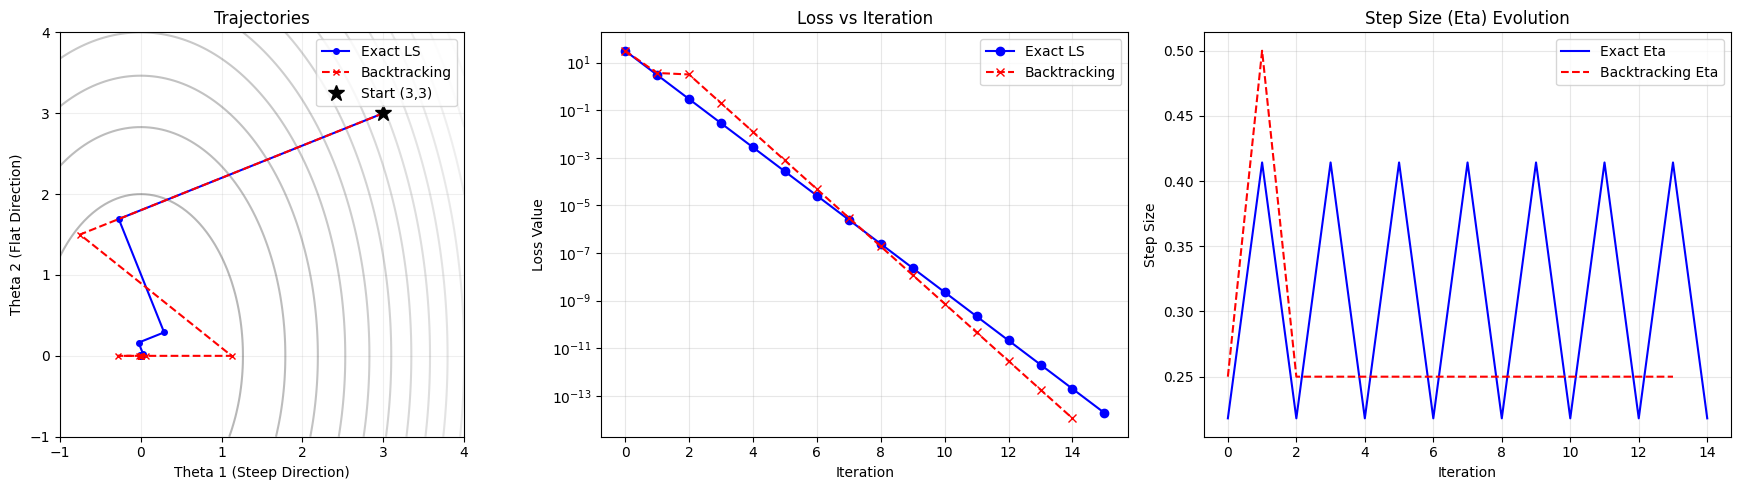

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Define Problem Data
# ==========================================
# Matrix A = [[5, 0], [0, 2]]
A = np.diag([5.0, 2.0])


def L(theta):
    """
    Quadratic Loss: L(theta) = 1/2 * theta.T * A * theta
    """
    return 0.5 * (theta.T @ A @ theta)


def grad_L(theta):
    """
    Gradient: A * theta
    """
    return A @ theta


# ==========================================
# 2. Method A: GD with EXACT Line Search
# ==========================================
def GD_exact_line_search(start_theta, maxitr=50, tol=1e-6):
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]
    losses = [L(theta)]
    etas = []
    for _ in range(maxitr):
        g = grad_L(theta)

        # check convergence (Gradient Norm)
        if np.linalg.norm(g) < tol:
            break

        # Exact line search formula
        # eta* = (g.T * g) / (g.T * A * g)
        # This formula minimizes the quadratic function along the direction -g
        numerator = g.T @ g
        denominator = g.T @ A @ g

        if denominator == 0:  # safety check
            eta = 0
        else:
            eta = numerator / denominator

        etas.append(eta)

        # update theta
        theta = theta - eta * g

        history.append(theta.copy())
        losses.append(L(theta))

    return np.array(history), losses, etas


# ==========================================
# 3. Method B: GD with Backtracking
# ==========================================
def backtracking(theta, eta0=1.0, beta=0.5, c=1e-4):
    eta = eta0
    g = grad_L(theta)
    g_norm2 = np.dot(g, g)

    # Armijo condition: sufficient decrease
    while L(theta - eta * g) > L(theta) - c * eta * g_norm2:
        eta *= beta
        if eta < 1e-8:
            break
    return eta


def GD_backtracking(start_theta, maxitr=50, tol=1e-6):
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]
    losses = [L(theta)]
    etas = []

    for _ in range(maxitr):
        g = grad_L(theta)

        if np.linalg.norm(g) < tol:
            break

        # compute eta via backtracking
        eta = backtracking(theta, eta0=1.0, beta=0.5)
        etas.append(eta)

        # update
        theta = theta - eta * g

        history.append(theta.copy())
        losses.append(L(theta))

    return np.array(history), losses, etas


# ==========================================
# 4. Run Comparisons
# ==========================================
theta_0 = [3.0, 3.0]

# Run Exact LS
path_exact, loss_exact, eta_exact = GD_exact_line_search(theta_0)

# Run Backtracking
path_back, loss_back, eta_back = GD_backtracking(theta_0)

# ==========================================
# 5. Visualization
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Trajectories on Level Sets ---
ax1 = axes[0]

# Setup grid for contours (Ensure it covers the start point 3,3)
x_range = np.linspace(-1, 4, 100)
y_range = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = 0.5 * (A[0, 0] * X**2 + A[1, 1] * Y**2)  # A is diagonal

# Draw Contours
ax1.contour(X, Y, Z, levels=15, cmap="gray", alpha=0.3)
ax1.set_aspect("equal")  # Crucial for showing orthogonality
ax1.grid(True, alpha=0.2)

# Plot Paths
ax1.plot(path_exact[:, 0], path_exact[:, 1], "o-", color="blue", label="Exact LS", markersize=4)
ax1.plot(path_back[:, 0], path_back[:, 1], "x--", color="red", label="Backtracking", markersize=4)
ax1.plot(theta_0[0], theta_0[1], "k*", markersize=12, label="Start (3,3)")

ax1.set_title("Trajectories")
ax1.set_xlabel("Theta 1 (Steep Direction)")
ax1.set_ylabel("Theta 2 (Flat Direction)")
ax1.legend()

# --- Plot 2: Loss Convergence ---
ax2 = axes[1]
ax2.plot(loss_exact, "b-o", label="Exact LS")
ax2.plot(loss_back, "r--x", label="Backtracking")
ax2.set_title("Loss vs Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss Value")
ax2.set_yscale("log")  # Log scale helps see convergence speed differences
ax2.grid(True, alpha=0.3)
ax2.legend()

# --- Plot 3: Step Sizes ---
ax3 = axes[2]
ax3.plot(eta_exact, "b-", label="Exact Eta")
ax3.plot(eta_back, "r--", label="Backtracking Eta")
ax3.set_title("Step Size (Eta) Evolution")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Step Size")
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

## 6. Comments & Comparison

### COMPARISON & ANALYSIS:

#### 1. Speed of Convergence:

- Exact Line Search is theoretically optimal per step, often leading to
  faster convergence (fewer iterations) compared to generic backtracking.
- However, notice that even Exact LS suffers from **"Zig-Zagging"** in
  ill-conditioned valleys. It always steps orthogonal to the previous gradient.

#### 2. Trajectory Shape:

- Exact LS: The steps are **perfectly orthogonal (90 degrees)**. Each step minimizes
  the function along that line, meaning the new gradient must be **perpendicular**
  to the search direction.
- Backtracking: The steps are not perfectly orthogonal. It accepts any step
  that is "good enough" (Armijo condition), so it might take **smaller, safer steps**.

#### 3. Smoothness of Step Sizes:

- Exact LS: The optimal $\eta$ fluctuates up and down. When moving along the
  flat direction ($\theta_2$), $\eta$ is large. When correcting the steep direction
  ($\theta_1$), $\eta$ is small.
- Backtracking: The $\eta$ values look like a "step function" or stay constant.
  If $\eta = 1.0$ works, it keeps using it. If it fails, it halves it (0.5, 0.25).
  It doesn't fine-tune the value like Exact LS does.


# Exercise 5: Gradient Descent on the Rosenbrock Function



--- Processing Start Point: [-1.5, 2.0] ---


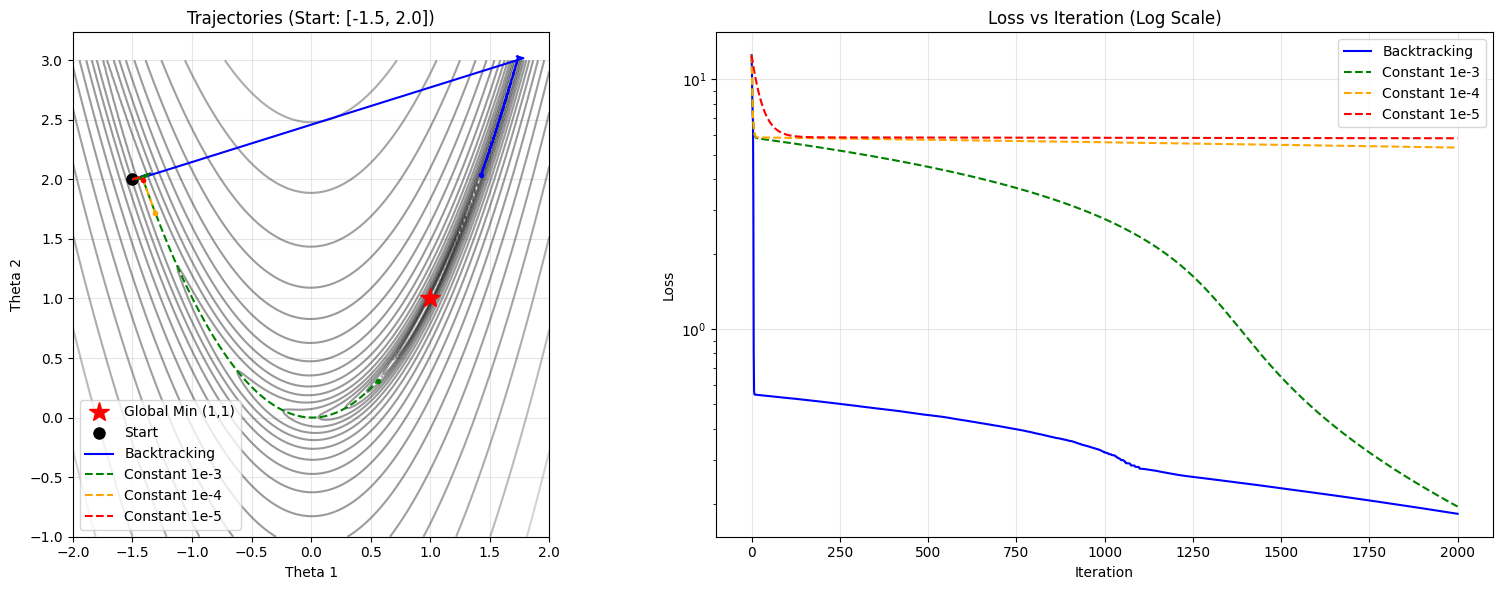

   Backtracking Final Pos: [1.4267741  2.03755039]
   Constant 1e-3 Final Pos: [0.55889403 0.31016555]

--- Processing Start Point: [-1.0, 0.0] ---


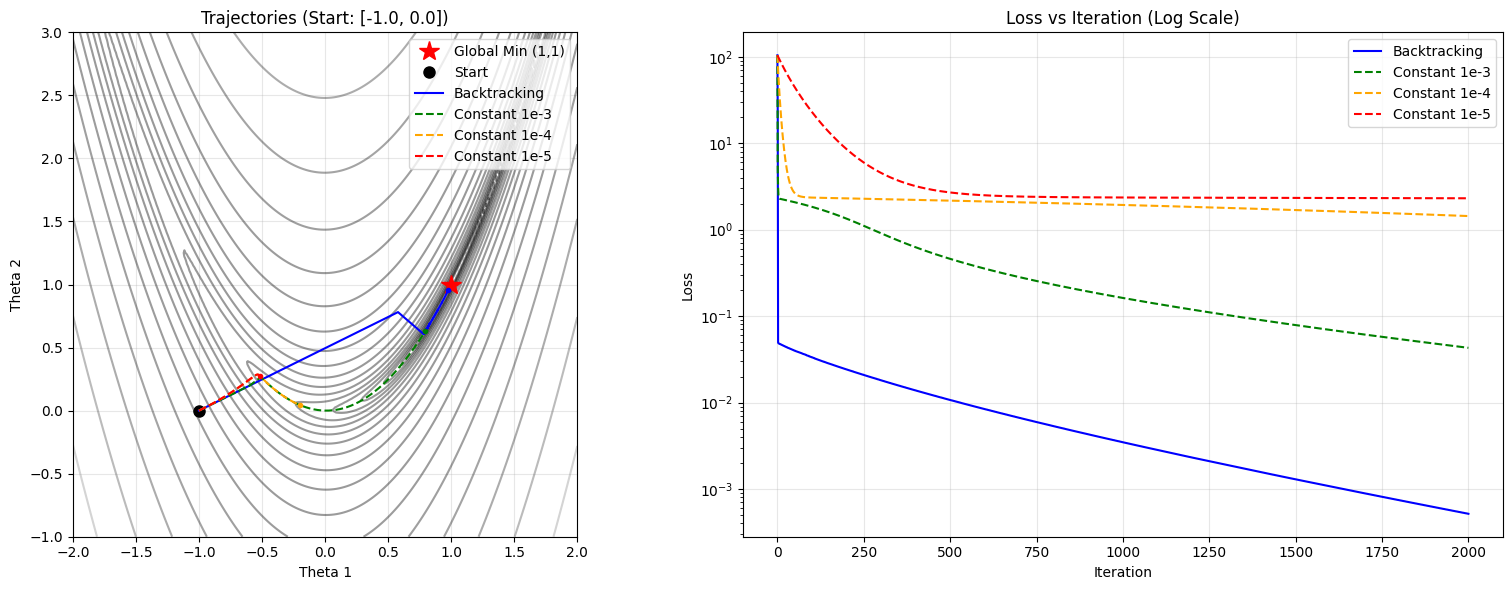

   Backtracking Final Pos: [0.9773184  0.95500198]
   Constant 1e-3 Final Pos: [0.79294864 0.62783253]

--- Processing Start Point: [0.0, 2.0] ---


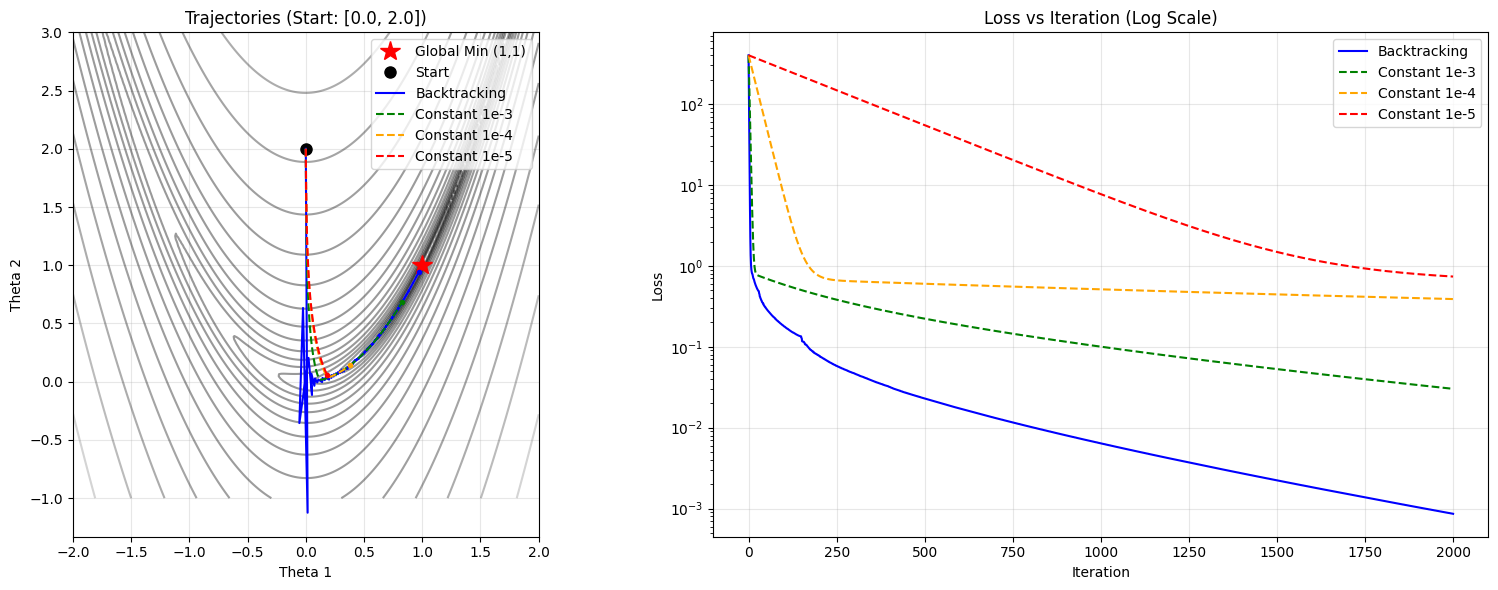

   Backtracking Final Pos: [0.97062944 0.94210092]
   Constant 1e-3 Final Pos: [0.82631779 0.68203119]

--- Processing Start Point: [1.5, 1.5] ---


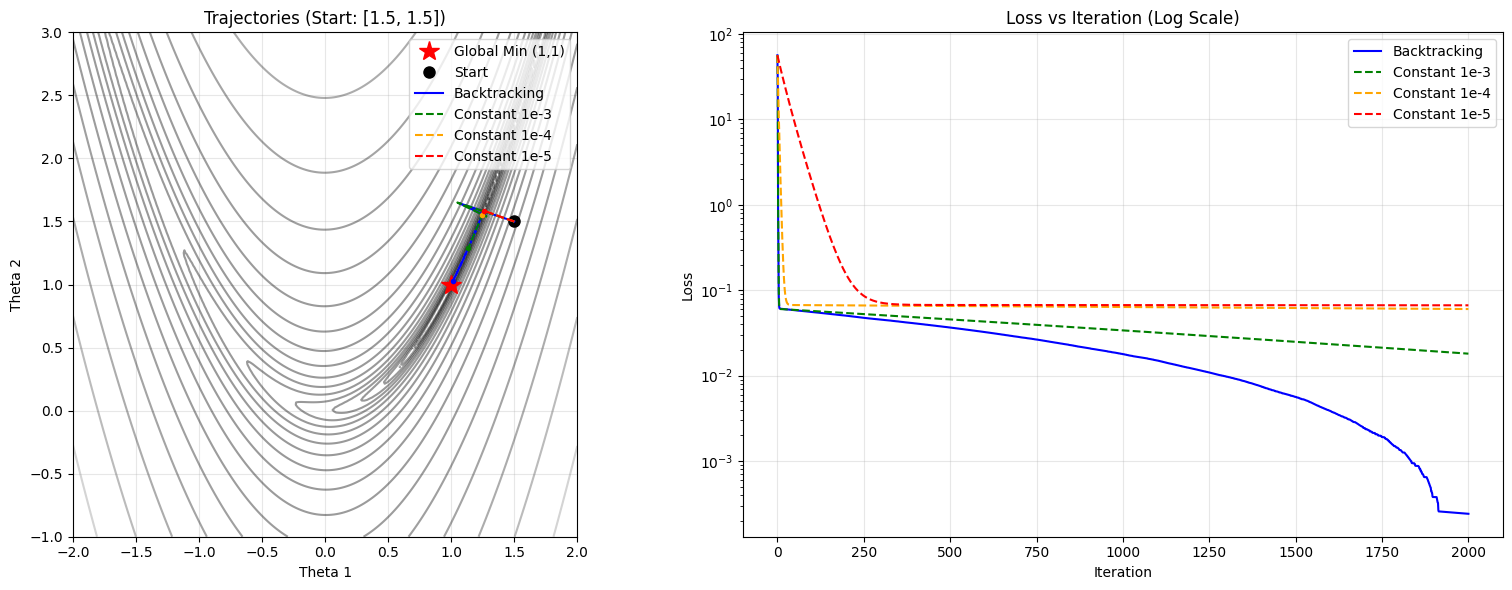

   Backtracking Final Pos: [1.01474524 1.02921889]
   Constant 1e-3 Final Pos: [1.1344633  1.28750334]


In [5]:
import numpy as np
import matplotlib.pyplot as plt


# ==========================================
# 1. Define Rosenbrock Function & Gradient
# ==========================================
def rosenbrock(theta):
    x, y = theta[0], theta[1]
    return (1 - x) ** 2 + 100 * (y - x**2) ** 2


def grad_rosenbrock(theta):
    x, y = theta[0], theta[1]
    # dL/dx = -2(1-x) - 400x(y - x^2)
    grad_x = -2 * (1 - x) - 400 * x * (y - x**2)
    # dL/dy = 200(y - x^2)
    grad_y = 200 * (y - x**2)
    return np.array([grad_x, grad_y])


# ==========================================
# 2. Optimization Algorithms
# ==========================================


# --- A. Backtracking Line Search (Class Implementation) ---
def backtracking(L, g, theta, eta0=1.0, beta=0.5, c=1e-4):
    eta = eta0
    g_norm2 = np.dot(g, g)

    # Armijo condition
    # Safety: Limit max iterations to avoid infinite loop if numerical precision issues arise
    max_checks = 100
    for _ in range(max_checks):
        if L(theta - eta * g) <= L(theta) - c * eta * g_norm2:
            break
        eta *= beta
    return eta


def gd_backtracking(start_theta, maxit=2000, tolL=1e-6, toltheta=1e-8):
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]
    losses = [rosenbrock(theta)]

    for k in range(maxit):
        # 1. Gradient
        g = grad_rosenbrock(theta)

        # 2. Compute optimal eta
        eta = backtracking(rosenbrock, g, theta, eta0=1.0, beta=0.5)

        # 3. Update
        theta_new = theta - eta * g

        # 4. Check Stopping Criteria
        step_norm = np.linalg.norm(theta_new - theta)
        grad_norm = np.linalg.norm(g)

        history.append(theta_new.copy())
        losses.append(rosenbrock(theta_new))

        if grad_norm < tolL or step_norm < toltheta:
            print(f"[Backtracking] Converged at iter {k}: L={losses[-1]:.4e}")
            break

        theta = theta_new

    return np.array(history), losses


# --- B. Constant Step Size GD ---
def gd_constant(start_theta, eta, maxit=2000, tolL=1e-6):
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]
    losses = [rosenbrock(theta)]

    for k in range(maxit):
        g = grad_rosenbrock(theta)

        # Divergence Check
        if np.linalg.norm(g) > 1e10 or np.isnan(g).any():
            print(f"[Constant eta={eta}] Diverged at iter {k}")
            break

        theta = theta - eta * g

        history.append(theta.copy())
        current_loss = rosenbrock(theta)
        losses.append(current_loss)

        if np.linalg.norm(g) < tolL:
            print(f"[Constant eta={eta}] Converged at iter {k}: L={current_loss:.4e}")
            break

    return np.array(history), losses


# ==========================================
# 3. Visualization Helper
# ==========================================
def plot_rosenbrock_results(start_point, methods_data):
    """
    Generates a figure with 2 subplots: Trajectory and Loss
    methods_data: dict of { 'Label': (path, losses, color, linestyle) }
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Trajectory on Contour Map ---
    # Range covering all start points and the solution (1,1)
    # Start point (-1.5, 2) is the widest X, (-1, 0) is lowest Y
    x_range = np.linspace(-2.0, 2.0, 200)
    y_range = np.linspace(-1.0, 3.0, 200)
    X, Y = np.meshgrid(x_range, y_range)
    Z = rosenbrock([X, Y])

    # Use Logarithmic levels because Rosenbrock varies wildly (0 to thousands)
    levels = np.logspace(-1, 3.5, 20)
    ax1.contour(X, Y, Z, levels=levels, cmap="gray", alpha=0.4)
    ax1.plot(1, 1, "r*", markersize=15, label="Global Min (1,1)")  # The target

    # Plot Start
    ax1.plot(start_point[0], start_point[1], "ko", markersize=8, label="Start")

    # Plot Paths
    for label, (path, losses, color, style) in methods_data.items():
        # Plot only if path is valid (not immediately diverged)
        if len(path) > 1:
            ax1.plot(path[:, 0], path[:, 1], color=color, linestyle=style, label=label, linewidth=1.5)
            # Mark end point
            ax1.plot(path[-1, 0], path[-1, 1], marker=".", color=color)

    ax1.set_title(f"Trajectories (Start: {start_point})")
    ax1.set_xlabel("Theta 1")
    ax1.set_ylabel("Theta 2")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect("equal")  # Important to see true turning angles

    # --- Plot 2: Loss Curves ---
    for label, (path, losses, color, style) in methods_data.items():
        if len(losses) > 1:
            ax2.plot(losses, color=color, linestyle=style, label=label, linewidth=1.5)

    ax2.set_title(f"Loss vs Iteration (Log Scale)")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss")
    ax2.set_yscale("log")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ==========================================
# 4. Main Execution
# ==========================================
start_points = [[-1.5, 2.0], [-1.0, 0.0], [0.0, 2.0], [1.5, 1.5]]

# We test specific constant step sizes + backtracking
test_etas = [1e-3, 1e-4, 1e-5]

for start in start_points:
    print(f"\n--- Processing Start Point: {start} ---")

    results = {}

    # 1. Run Backtracking
    path_bt, loss_bt = gd_backtracking(start)
    results["Backtracking"] = (path_bt, loss_bt, "blue", "-")

    # 2. Run Constant Step Sizes
    colors = ["green", "orange", "red"]
    for i, eta in enumerate(test_etas):
        path_c, loss_c = gd_constant(start, eta)
        results[f"Constant 1e-{3+i}"] = (path_c, loss_c, colors[i], "--")

    # 3. Plot
    plot_rosenbrock_results(start, results)

    # 4. Brief Analysis for Console
    print(f"   Backtracking Final Pos: {path_bt[-1]}")
    print(f"   Constant 1e-3 Final Pos: {results['Constant 1e-3'][0][-1]}")

---
### Observations and Analysis of Gradient Descent on the Rosenbrock Function

#### 1. Whether the method enters the valley

Backtracking Gradient Descent:
The algorithm generally succeeds in entering the curved Rosenbrock valley near the region where x is close to 1 and y is close to x². Because the step size is adjusted by the line search, it can take larger steps in flat regions and smaller steps in regions with strong curvature, which helps it move toward the valley instead of overshooting.

Gradient Descent with Constant Step Size:

* With step size eta = 1e-3, the method often overshoots the sides of the valley or becomes unstable, and in some initializations it may fail to enter the valley.
* With step size eta = 1e-4, the algorithm eventually enters the valley, but only after many iterations.
* With step size eta = 1e-5, the algorithm remains stable, but progress is extremely slow and the iterates stay far from the valley for a long time.

Conclusion: Entering the valley is highly sensitive to the choice of constant step size, while backtracking reliably adapts and usually succeeds.

---

#### 2. How long it takes to “turn” along the valley direction

The Rosenbrock valley is curved. When Gradient Descent first reaches the valley, the gradient direction is almost perpendicular to the direction of the valley floor.

Constant Step Size GD:
The iterates bounce back and forth between the two valley walls. It takes many iterations before the trajectory aligns with the valley direction, because each step overshoots and forces the method to gradually “turn” along the valley.

Backtracking GD:
The method turns more quickly. As the curvature becomes stronger, the line search automatically reduces the step size, which prevents large sideways jumps and lets the trajectory begin following the valley sooner.

---

#### 3. Whether the method zig-zags

Constant Step Size GD (eta = 1e-3 or 1e-4):
Strong zig-zag motion is visible inside the valley. The iterates repeatedly cross from one side of the valley to the other because the gradient alternates toward opposite walls.

Constant Step Size GD with very small eta (1e-5):
Zig-zagging decreases, but the method becomes extremely slow and needs many iterations to make visible progress.

Backtracking GD:
Zig-zag behavior still appears (because it is caused by the geometry of the function), but the oscillations are smaller and the trajectory is smoother than with a large fixed step size.

---

#### 4. Whether step sizes become too small or too large

Constant Step Size GD:

- Large step size (eta = 1e-3): steps are too large, causing oscillation or divergence.
- Medium step size (eta = 1e-4): stable, but inefficient and strongly zig-zagging.
- Small step size (eta = 1e-5): steps are too small, so convergence becomes very slow.

This shows that choosing a single fixed learning rate is difficult for the Rosenbrock function.

Backtracking GD:
The step size is automatically adjusted:

- Larger in flat regions,
- Smaller in the narrow curved valley.
  This prevents divergence while still allowing faster progress than very small fixed step sizes.

---

#### Overall Conclusion

The Rosenbrock function demonstrates that Gradient Descent with a fixed step size is either unstable (when the step size is large) or very slow (when the step size is small). Backtracking line search adapts the step size to the local curvature, helping the method enter the valley more reliably, turn along its curved direction sooner, and converge with smoother and more stable progress.
